## Mask Data(Kaggle)

https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset

In [2]:
# 압축파일 관리 툴
import zipfile

content_zip = zipfile.ZipFile('./data/archive.zip') # 압축 해제
content_zip.extractall('./data')

content_zip.close()

In [8]:
import os
os.listdir('./data/Face Mask Dataset/') # 폴더 내 파일명(디렉토리명) 확인 가능

['Test', 'Train', 'Validation']

In [9]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

현재 폴더 구조

- data
    - Face Mask Dataset
        - Test
            - WithMask
                - *.png
            - WithoutMask
                - *.png
        - Train
            - WithMask
                - *.png
            - WithoutMask
                - *.png
        - Validation
            - WithMask
                - *.png
            - WithoutMask
                - *.png

In [10]:
# 파일을 정리해보자.
path = "./data/Face Mask Dataset/"
dataset = {'image_path' : [], 'mask_status' : [], 'where': []}

for where in os.listdir(path): # where은 위에서 보았다시피 Test, Train, Validation이 된다
    for status in os.listdir(path + "/" + where): # WithMask , WithoutMask
        for image in glob.glob(path + where + '/' + status + '/' + '*.png'):
            dataset['image_path'].append(image)
            dataset['mask_status'].append(status)
            dataset['where'].append(where)

In [11]:
# 데이터프레임화
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,./data/Face Mask Dataset/Test/WithMask\1163.png,WithMask,Test
1,./data/Face Mask Dataset/Test/WithMask\1174.png,WithMask,Test
2,./data/Face Mask Dataset/Test/WithMask\1175.png,WithMask,Test
3,./data/Face Mask Dataset/Test/WithMask\1203.png,WithMask,Test
4,./data/Face Mask Dataset/Test/WithMask\1361.png,WithMask,Test


In [20]:
dataset['mask_status'].unique()

array(['WithMask', 'WithoutMask'], dtype=object)

With Mask :  5909
Without Mask :  5883


<Axes: xlabel='mask_status', ylabel='count'>

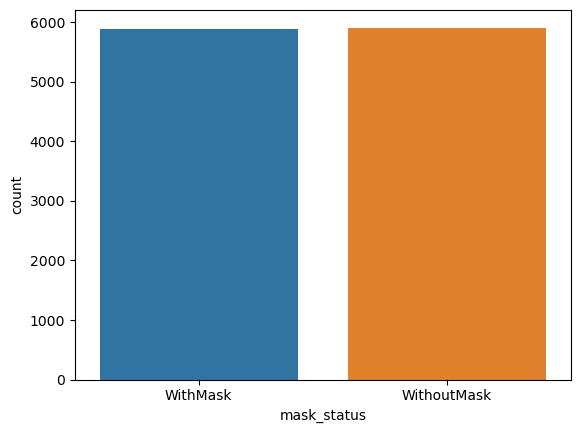

In [12]:
# mask_status 분포 확인
print("With Mask : ", dataset.value_counts('mask_status')[0])
print("Without Mask : ", dataset.value_counts('mask_status')[1])

sns.countplot(x = dataset['mask_status'])

데이터는 고르게 있다.

In [14]:
pip install opencv-python # cv2 설치

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/38/d2/3e8c13ffc37ca5ebc6f382b242b44acb43eb489042e1728407ac3904e72f/opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.1 MB 2.0 MB/s eta 0:00:20
   ---------------------------------------- 0.1/38.1 MB 1.7 MB/s eta 0:00:23
   ---------------------------------------- 0.2/38.1 MB 1.3 MB/s eta 0:00:29
   ---------------------------------------- 0.2/38.1 MB 1.2 MB/s eta 0:00:32
   ---------------------------------------- 0.3/38.1 MB 1.2 MB/s eta 0:00:33
   ---------------------------------------- 0.4/38.1 MB 1.4 MB/s eta 0:00:27
    --------------------------------------- 0.5/38.1 MB 1.5 MB/s eta 0:00:26
    --------------------------------------- 0.6/38.1 MB 1.5 MB/s eta 0:00:25
    --------------------------------------- 0.8/38.1 MB 1.8 MB/s eta 0:00:21
   - -----------

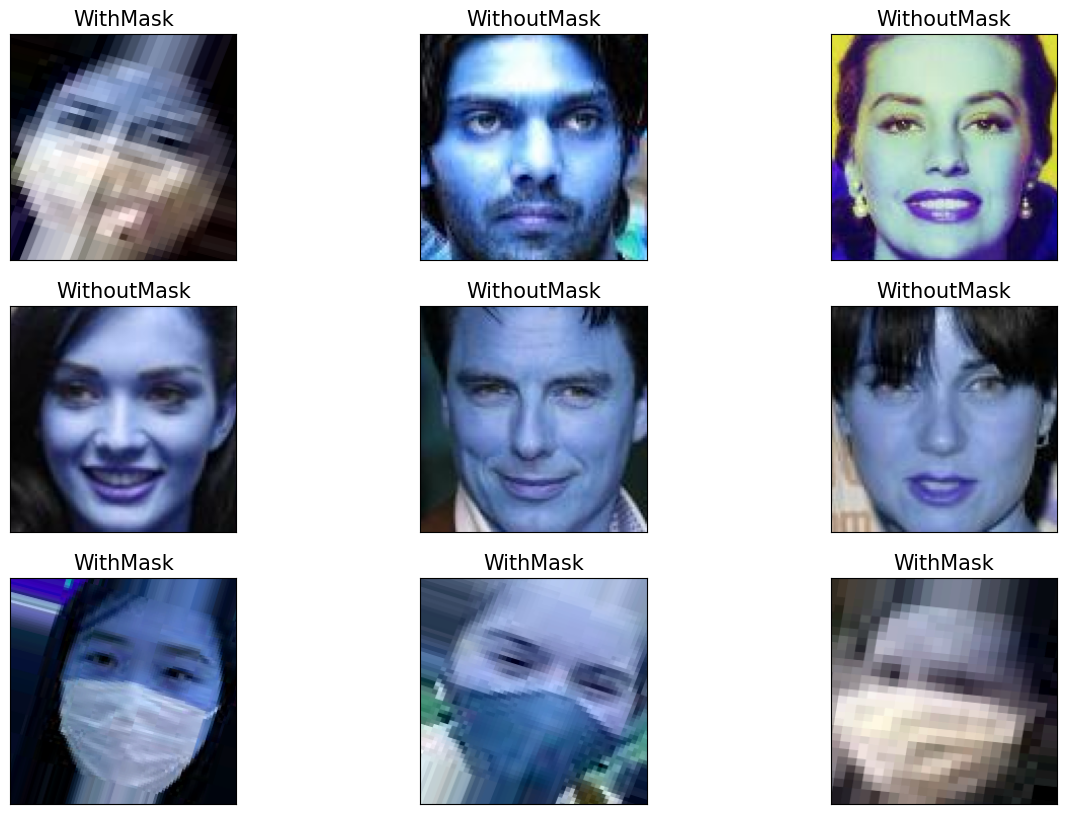

In [15]:
# 랜덤하게 어떤 사진들이 있는지 확인
import cv2

plt.figure(figsize=(15, 10))
for i in range(9):
    random = np.random.randint(1, len(dataset))
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.imread(dataset.loc[random, 'image_path']))
    plt.title(dataset.loc[random, 'mask_status'], size = 15)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [16]:
# Train, Test, Val 데이터가 분리되어있는대로 사용
train_df = dataset[dataset['where'] == 'Train']
test_df = dataset[dataset['where'] == 'Test']
val_df = dataset[dataset['where'] == 'Validation']

train_df.head()

,image_path,mask_status,where
992,./data/Face Mask Dataset/Train/WithMask\10.png,WithMask,Train
993,./data/Face Mask Dataset/Train/WithMask\100.png,WithMask,Train
994,./data/Face Mask Dataset/Train/WithMask\1004.png,WithMask,Train
995,./data/Face Mask Dataset/Train/WithMask\1005.png,WithMask,Train
996,./data/Face Mask Dataset/Train/WithMask\1006.png,WithMask,Train


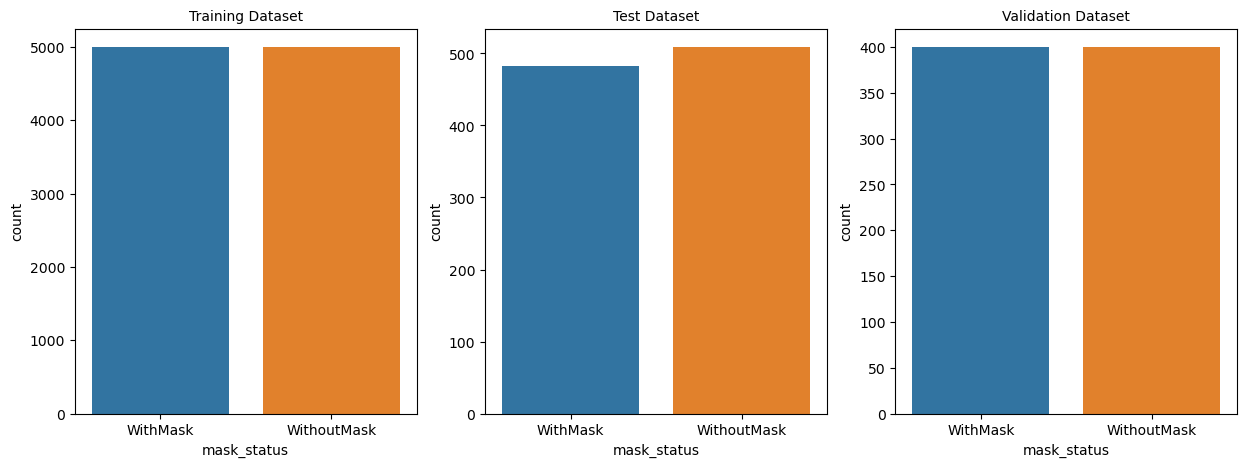

In [17]:
# Train, Test, Val 데이터 분포 확인
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x = train_df['mask_status'])
plt.title('Training Dataset', size = 10)

plt.subplot(1, 3, 2)
sns.countplot(x = test_df['mask_status'])
plt.title('Test Dataset', size = 10)

plt.subplot(1, 3, 3)
sns.countplot(x = val_df['mask_status'])
plt.title('Validation Dataset', size = 10)

plt.show()

데이터셋 모두 마스크의 상태의 데이터가 고르게 분포되어있다.

In [18]:
# 인덱스 정리
train_df = train_df.reset_index().drop('index', axis = 1)
train_df.head()

,image_path,mask_status,where
0,./data/Face Mask Dataset/Train/WithMask\10.png,WithMask,Train
1,./data/Face Mask Dataset/Train/WithMask\100.png,WithMask,Train
2,./data/Face Mask Dataset/Train/WithMask\1004.png,WithMask,Train
3,./data/Face Mask Dataset/Train/WithMask\1005.png,WithMask,Train
4,./data/Face Mask Dataset/Train/WithMask\1006.png,WithMask,Train


### 데이터 전처리

In [21]:
data = []
image_size = 150

for i in range(len(train_df)):
    # grayscale 변환
    img_array = cv2.imread(train_df['image_path'][i], cv2.IMREAD_GRAYSCALE)

    # resizing
    new_image_array = cv2.resize(img_array , (image_size, image_size))

    # encoding 
    # withmask를 1로 표시
    if train_df['mask_status'][i] == 'WithMask':
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [22]:
data

[[array([[238, 238, 238, ..., 199, 199, 199],
         [238, 238, 238, ..., 197, 197, 197],
         [237, 237, 238, ..., 194, 194, 195],
         ...,
         [236, 236, 236, ..., 151, 151, 152],
         [235, 235, 235, ..., 151, 152, 152],
         [235, 235, 235, ..., 151, 152, 152]], dtype=uint8),
  1],
 [array([[ 66,  66,  66, ..., 119, 119, 119],
         [ 66,  66,  66, ..., 119, 119, 119],
         [ 66,  66,  66, ..., 119, 119, 119],
         ...,
         [ 97,  97,  97, ...,  50,  50,  50],
         [ 97,  97,  97, ...,  50,  50,  50],
         [ 97,  97,  97, ...,  50,  50,  50]], dtype=uint8),
  1],
 [array([[ 15,  15,  13, ...,  44,  45,  45],
         [ 15,  15,  13, ...,  44,  45,  45],
         [ 10,  10,   9, ...,  44,  45,  45],
         ...,
         [109, 109, 112, ...,  50,  45,  45],
         [108, 108, 110, ...,  47,  42,  42],
         [108, 108, 110, ...,  47,  42,  42]], dtype=uint8),
  1],
 [array([[106, 106, 103, ...,  76,  80,  80],
         [106, 106, 1

In [23]:
# mask_status 가 랜덤하게 섞일 수 있도록 shuffle
np.random.shuffle(data)

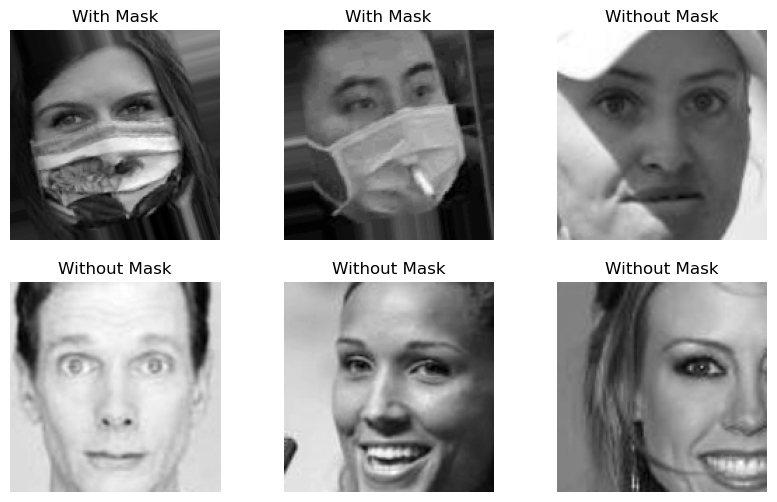

In [24]:
fig, ax = plt.subplots(2, 3, figsize = (10, 6))

for row in range(2):
    for col in range(3):
        image_index = row * 100 + col

        ax[row, col].axis('off')
        ax[row, col].imshow(data[image_index][0], cmap = 'gray')

        if data[image_index][1] == 0:
            ax[row, col].set_title('Without Mask')
        else:
            ax[row, col].set_title('With Mask')

In [25]:
# 데이터 저장
X = []
y = []

for image in data:
    X.append(image[0])
    y.append(image[1])

X = np.array(X)
y = np.array(y)

In [26]:
# 그냥 한 번 더 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

In [28]:
# 모델링(LeNet)
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, kernel_size = (5, 5), strides = (1, 1), padding = 'same',
                  activation = 'relu', input_shape = (150, 150, 1)),
    layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
    layers.Conv2D(64, (2, 2), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = (2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid') # 단일분류이므로 출력은 1개로
])

model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), 
              metrics = ['accuracy'])

In [29]:
# 학습
# (크기, 해상도1, 해상도2, 채널)
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)
history = model.fit(X_train, y_train, epochs=4, batch_size=32)

Epoch 1/4
250/250 [==============================] - 173s 689ms/step - loss: 27.4922 - accuracy: 0.8698
Epoch 2/4
250/250 [==============================] - 237s 944ms/step - loss: 0.0613 - accuracy: 0.9766
Epoch 3/4
250/250 [==============================] - 222s 887ms/step - loss: 0.0362 - accuracy: 0.9868
Epoch 4/4
250/250 [==============================] - 210s 840ms/step - loss: 0.0232 - accuracy: 0.9920


In [30]:
# 성능
model.evaluate(X_val, y_val)

63/63 [==============================] - 5s 74ms/step - loss: 0.0970 - accuracy: 0.9710


[0.09700915217399597, 0.9710000157356262]

accuracy는 좋아보인다!

In [31]:
# 0.5보다 큰 경우 1로 취급
prediction = (model.predict(X_val) > 0.5).astype('int32')

print(classification_report(y_val, prediction))
print(confusion_matrix(y_val, prediction))

63/63 [==============================] - 5s 76ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       980
           1       0.97      0.97      0.97      1020

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

[[953  27]
 [ 31 989]]


In [32]:
# 틀린 것에 대한 확인
wrong_result = []
for n in range(0,len(y_val)):
    if prediction[n] != y_val[n]:
        wrong_result.append(n)
len(wrong_result)

58

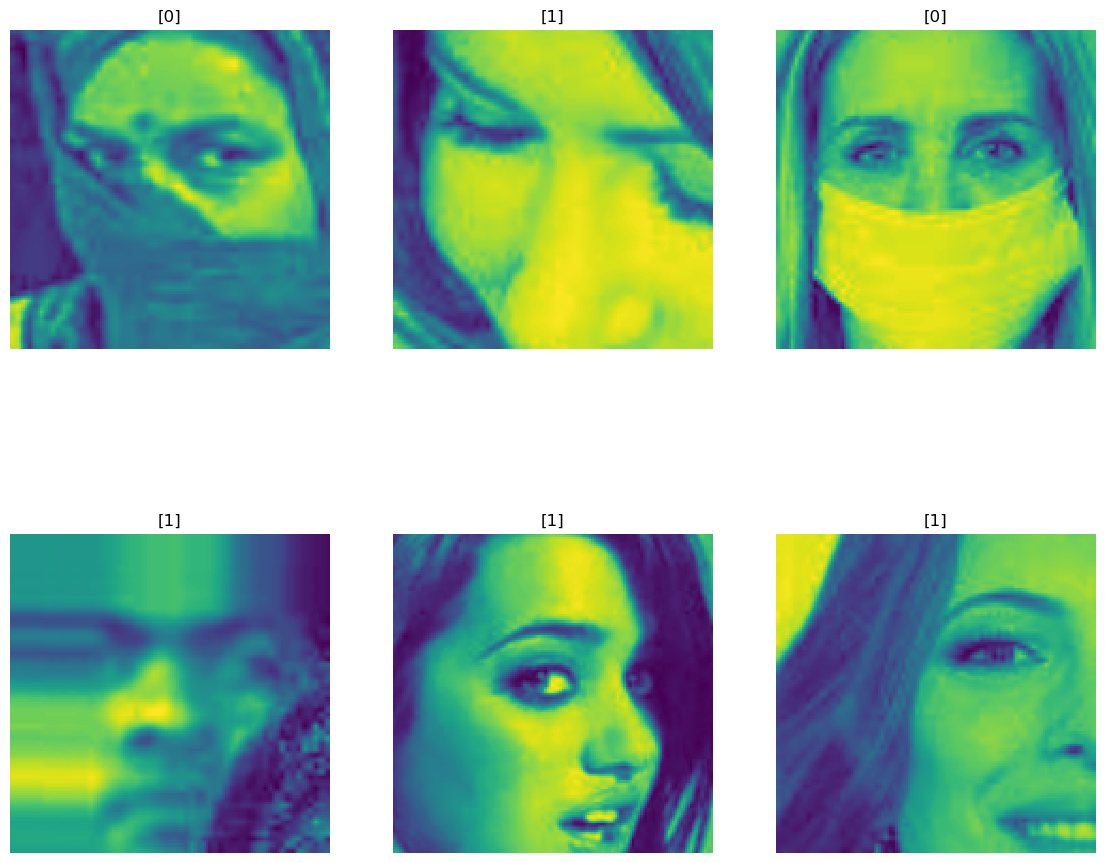

In [42]:
import random

samples = random.choices(population = wrong_result, k = 6)

plt.figure(figsize = (14, 12))

for idx, n in enumerate(samples):
    plt.subplot(2, 3, idx + 1)
    plt.imshow(X_val[n].reshape(150, 150), interpolation='nearest')
    plt.title(prediction[n])
    plt.axis('off')

plt.show()

## OX 분류

In [ ]:
import os
os.listdir('./data/OX HandWriting/') # 폴더 내 파일명(디렉토리명) 확인 가능

In [ ]:
from glob import glob

train = glob('./data/OX HandWriting/train/*')
train

In [ ]:
from skimage.transform import rescale, resize
from skimage import color
from skimage.io import imread, imsave
import matplotlib.pyplot as plt


image = imread(train[0])
image = color.rgb2gray(image)
plt.imshow(image, cmap = 'gray')

In [ ]:
image.shape

In [ ]:
# resize
img_resized = resize(image, (28, 28))
print(img_resized.shape)
plt.imshow(img_resized, cmap = 'gray')

In [ ]:
# 저장하기
imsave('./data/OX HandWriting/tmp.png', np.round(img_resized*255).astype(np.uint8))